In [1]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import itertools
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [2]:
FIGURE_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Code/figures/"
DATA_PATH = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/Data/"
DATA_LOAD_PATH = DATA_PATH + "original_data/"
INPUT_MODEL_PATH = DATA_PATH + "processed_data/"
MODEL_SAVE_PATH = DATA_PATH + "trained_models/"
RESULTS_PATH = DATA_PATH + "model_results/"
path_to_shapefile = "C:/Users/vitas/Desktop/LE PINN/pinn.global.dust/pinn.global.dust/ne_110m_admin_0_countries.shp"
world = gpd.read_file(path_to_shapefile)
with open("functions_training_model.py", 'r') as file:
    content = file.read()

# Execute the content of the .py file
exec(content)
df_empirical_Holocene = pd.read_csv(INPUT_MODEL_PATH + "df_empirical_Holocene.csv")
df_global_grid = pd.read_csv(INPUT_MODEL_PATH + "df_global_grid.csv")
df_wind = pd.read_csv(INPUT_MODEL_PATH + "df_wind.csv", usecols=['wind', 'latitude'])

latitude_wind = torch.tensor(df_wind['latitude'].values / 90, dtype=torch.float32)
mean_wind = torch.tensor(df_wind['wind'].values / df_wind['wind'].max(), dtype=torch.float32)


def wind_func(lat_tensor):
    # Interpolazione lineare in PyTorch
    return torch.interp(lat_tensor.flatten(), latitude_wind, mean_wind).unsqueeze(1)





In [3]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.activation = nn.SiLU()
        layer_list = []

        for i in range(len(layers) - 1):
            layer_list.append(nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                layer_list.append(self.activation)
        self.model = nn.Sequential(*layer_list)

    def forward(self, x):
        return self.model(x)


In [4]:
# PDE
D = torch.nn.Parameter(torch.tensor(1.0, requires_grad=True))


def pde_residual(model, x, wind_func, D):
    x.requires_grad_(True)
    u = model(x)

    grad_u = autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivate parziali
    du_dx = grad_u[:, 0:1]
    du_dy = grad_u[:, 1:2]

    # Secondi ordini
    d2u_dx2 = autograd.grad(du_dx, x, grad_outputs=torch.ones_like(du_dx), create_graph=True)[0][:, 0:1]
    d2u_dy2 = autograd.grad(du_dy, x, grad_outputs=torch.ones_like(du_dy), create_graph=True)[0][:, 1:2]

    # Coefficiente K in funzione della latitudine (seconda colonna di x)
    K = wind_func(x[:, 1:2])

    # Residuo PDE (esempio diffusione anisotropa)
    residual = (-K * du_dx * (1 / torch.cos(x[:, 1:2] * np.pi / 2)) + D * (
        (1 / (torch.cos(x[:, 1:2] * np.pi / 2) ** 2) * d2u_dx2 + d2u_dy2 - torch.tan(x[:, 1:2] * np.pi / 2) * du_dy)))
    return residual


In [5]:
# === PARAMETRI DEL DOMINIO ===
x_min, x_max = -2.0, 2.0
y_min, y_max = -0.89, 0.89

# === 1. DATI OSSERVATI ===
# Assumi che lon/lat siano già scalati correttamente in [-2, 2] e [-0.89, 0.89]
X_obs = torch.tensor(df_empirical_Holocene[['lon', 'lat']].values / 90, dtype=torch.float32)
Y_obs = torch.tensor(df_empirical_Holocene['log_dep_norm'].values.reshape(-1, 1), dtype=torch.float32)

# Verifica range
print("Range X_obs:", X_obs[:, 0].min().item(), X_obs[:, 0].max().item())
print("Range Y_obs:", X_obs[:, 1].min().item(), X_obs[:, 1].max().item())

# === 2. PUNTI INTERNI (PDE) ===
N_pde = 3000

xy_pde = torch.cat([
    torch.rand(N_pde, 1) * (x_max - x_min) + x_min,  # x in [x_min, x_max]
    torch.rand(N_pde, 1) * (y_max - y_min) + y_min  # y in [y_min, y_max]
], dim=1)

# === 3. CONDIZIONI AL CONTORNO DIRICHLET ===

# Nord: y = y_max
N_bc = 200
X_north = torch.rand(N_bc, 1) * (x_max - x_min) + x_min
Y_north = torch.full_like(X_north, y_max)
X_bc_north = torch.cat([X_north, Y_north], dim=1)
Y_bc_north = torch.full((N_bc, 1), -1.0)  # Valore BC nord

# Sud: y = y_min
X_south = torch.rand(N_bc, 1) * (x_max - x_min) + x_min
Y_south = torch.full_like(X_south, y_min)
X_bc_south = torch.cat([X_south, Y_south], dim=1)
Y_bc_south = torch.full((N_bc, 1), -2.0)  # Valore BC sud

# === 4. CONDIZIONI PERIODICHE (x = x_min e x = x_max) ===
N_periodic = 200
Y_periodic = torch.linspace(y_min, y_max, N_periodic).unsqueeze(1)

X_periodic_left = torch.full_like(Y_periodic, x_min)
X_periodic_right = torch.full_like(Y_periodic, x_max)

X_periodic_left = torch.cat([X_periodic_left, Y_periodic], dim=1)
X_periodic_right = torch.cat([X_periodic_right, Y_periodic], dim=1)


Range X_obs: -1.983555555343628 1.996666669845581
Range Y_obs: -0.8888888955116272 0.8763333559036255


In [6]:
# K in funzione della latitudine (normalizzata)
def wind_func(lat_tensor):
    return 1.0 + 0.5 * torch.sin(np.pi * lat_tensor)  # funzione fittizia


In [7]:
def total_loss(model, X_obs, Y_obs, xy_pde, X_bc1, Y_bc1,
               X_bc2, Y_bc2, X_periodic_left, X_periodic_right,
               wind_func, D,
               lambda_obs=5.0, lambda_pde=10.0, lambda_bc1=0.5, lambda_bc2=0.5,
               lambda_per0=1.0, lambda_per1=1.0):
    # Loss osservati
    pred_obs = model(X_obs)
    loss_obs = nn.MSELoss()(pred_obs, Y_obs)

    # PDE residual
    res_pde = pde_residual(model, xy_pde, wind_func, D)
    loss_pde = torch.mean(res_pde ** 2)

    # BC1 Dirichlet (esempio)
    pred_bc1 = model(X_bc1)
    loss_bc1 = nn.MSELoss()(pred_bc1, Y_bc1)

    # BC2 Dirichlet (esempio)
    pred_bc2 = model(X_bc2)
    loss_bc2 = nn.MSELoss()(pred_bc2, Y_bc2)

    # Condizione periodica sul valore (ordine derivata 0)
    u_left = model(X_periodic_left)
    u_right = model(X_periodic_right)
    loss_per0 = nn.MSELoss()(u_left, u_right)

    # Condizione periodica sulla derivata (ordine derivata 1)
    # Calcolo derivata in X_periodic_left e X_periodic_right
    x_left = X_periodic_left.clone().detach().requires_grad_(True)
    x_right = X_periodic_right.clone().detach().requires_grad_(True)

    u_left = model(x_left)
    u_right = model(x_right)

    grad_left = autograd.grad(u_left, x_left, grad_outputs=torch.ones_like(u_left), create_graph=True)[0][:, 0:1]
    grad_right = autograd.grad(u_right, x_right, grad_outputs=torch.ones_like(u_right), create_graph=True)[0][:, 0:1]

    loss_per1 = nn.MSELoss()(grad_left, grad_right)

    # Somma pesata
    total = (lambda_obs * loss_obs + lambda_pde * loss_pde +
             lambda_bc1 * loss_bc1 + lambda_bc2 * loss_bc2 +
             lambda_per0 * loss_per0 + lambda_per1 * loss_per1)

    return total, loss_obs.item(), loss_pde.item(), loss_bc1.item(), loss_bc2.item(), loss_per0.item(), loss_per1.item()


In [8]:
# 4. Allena modello con rmsprop
model_rmsprop = PINN(layers=[2, 32, 32, 32, 32, 32, 1])
D_rmsprop = torch.nn.Parameter(torch.tensor(1.0, requires_grad=True))
params_rmsprop = list(model_rmsprop.parameters()) + [D_rmsprop]
optimizer_rmsprop = torch.optim.RMSprop(params_rmsprop, lr=1e-4)


# 3. Definisci i pesi (lambda) manualmente
lambda_obs = 20
lambda_pde = 8
lambda_bc1 = 3
lambda_bc2 = 3
lambda_per0 = 1
lambda_per1 = 1

epochs_adam = 10000
loss_history_rmsprop = []

for epoch in range(epochs_adam):
    optimizer_rmsprop.zero_grad()
    loss, l_obs, l_pde, l_bc1, l_bc2, l_per0, l_per1 = total_loss(
        model_rmsprop, X_obs, Y_obs, xy_pde, X_bc_north, Y_bc_north, X_bc_south, Y_bc_south,
        X_periodic_left, X_periodic_right, wind_func, D_rmsprop,
        lambda_obs=lambda_obs, lambda_pde=lambda_pde, lambda_bc1=lambda_bc1, lambda_bc2=lambda_bc2,
        lambda_per0=lambda_per0, lambda_per1=lambda_per1
    )
    loss.backward()
    optimizer_rmsprop.step()

    loss_history_rmsprop.append([loss.item(),
                         lambda_obs * l_obs,
                         lambda_pde * l_pde,
                         lambda_bc1 * l_bc1 + lambda_bc2 * l_bc2,
                         lambda_per0 * l_per0,
                         lambda_per1 * l_per1
                         ])



In [9]:
# 4. Allena modello con rmsprop
model_adagrad = PINN(layers=[2, 32, 32, 32, 32, 32, 1])
D_adagrad= torch.nn.Parameter(torch.tensor(1.0, requires_grad=True))
params_adagrad = list(model_adagrad.parameters()) + [D_adagrad]
optimizer_adagrad= torch.optim.Adagrad(params_adagrad, lr=1e-4)


# 3. Definisci i pesi (lambda) manualmente
lambda_obs = 20
lambda_pde = 8
lambda_bc1 = 3
lambda_bc2 = 3
lambda_per0 = 1
lambda_per1 = 1

epochs_adam = 10000
loss_history_adagrad = []

for epoch in range(epochs_adam):
    optimizer_adagrad.zero_grad()
    loss, l_obs, l_pde, l_bc1, l_bc2, l_per0, l_per1 = total_loss(
        model_adagrad, X_obs, Y_obs, xy_pde, X_bc_north, Y_bc_north, X_bc_south, Y_bc_south,
        X_periodic_left, X_periodic_right, wind_func, D_adagrad,
        lambda_obs=lambda_obs, lambda_pde=lambda_pde, lambda_bc1=lambda_bc1, lambda_bc2=lambda_bc2,
        lambda_per0=lambda_per0, lambda_per1=lambda_per1
    )
    loss.backward()
    optimizer_adagrad.step()

    loss_history_adagrad.append([loss.item(),
                         lambda_obs * l_obs,
                         lambda_pde * l_pde,
                         lambda_bc1 * l_bc1 + lambda_bc2 * l_bc2,
                         lambda_per0 * l_per0,
                         lambda_per1 * l_per1
                         ])



In [10]:
model_adam = PINN(layers=[2, 32, 32, 32, 32, 32, 1])
D_adam= torch.nn.Parameter(torch.tensor(1.0, requires_grad=True))
params_adam = list(model_adam.parameters()) + [D_adam]
optimizer_adam= torch.optim.Adam(params_adam, lr=1e-4)


# 3. Definisci i pesi (lambda) manualmente
lambda_obs = 20
lambda_pde = 8
lambda_bc1 = 3
lambda_bc2 = 3
lambda_per0 = 1
lambda_per1 = 1

epochs_adam = 10000
loss_history_adam= []

for epoch in range(epochs_adam):
    optimizer_adam.zero_grad()
    loss, l_obs, l_pde, l_bc1, l_bc2, l_per0, l_per1 = total_loss(
        model_adagrad, X_obs, Y_obs, xy_pde, X_bc_north, Y_bc_north, X_bc_south, Y_bc_south,
        X_periodic_left, X_periodic_right, wind_func, D_adam,
        lambda_obs=lambda_obs, lambda_pde=lambda_pde, lambda_bc1=lambda_bc1, lambda_bc2=lambda_bc2,
        lambda_per0=lambda_per0, lambda_per1=lambda_per1
    )
    loss.backward()
    optimizer_adam.step()

    loss_history_adam.append([loss.item(),
                         lambda_obs * l_obs,
                         lambda_pde * l_pde,
                         lambda_bc1 * l_bc1 + lambda_bc2 * l_bc2,
                         lambda_per0 * l_per0,
                         lambda_per1 * l_per1
                         ])



In [11]:
model_adam2 = PINN(layers=[2, 32, 32, 32, 32, 32, 1])
D_adam2= torch.nn.Parameter(torch.tensor(1.0, requires_grad=True))
params_adam2 = list(model_adam2.parameters()) + [D_adam]
optimizer_adam2= torch.optim.Adam(params_adam2, lr=1e-4,betas=(0.8, 0.98))


# 3. Definisci i pesi (lambda) manualmente
lambda_obs = 20
lambda_pde = 8
lambda_bc1 = 3
lambda_bc2 = 3
lambda_per0 = 1
lambda_per1 = 1

epochs_adam2 = 10000
loss_history_adam2= []

for epoch in range(epochs_adam2):
    optimizer_adam2.zero_grad()
    loss, l_obs, l_pde, l_bc1, l_bc2, l_per0, l_per1 = total_loss(
        model_adagrad, X_obs, Y_obs, xy_pde, X_bc_north, Y_bc_north, X_bc_south, Y_bc_south,
        X_periodic_left, X_periodic_right, wind_func, D_adam2,
        lambda_obs=lambda_obs, lambda_pde=lambda_pde, lambda_bc1=lambda_bc1, lambda_bc2=lambda_bc2,
        lambda_per0=lambda_per0, lambda_per1=lambda_per1
    )
    loss.backward()
    optimizer_adam2.step()

    loss_history_adam2.append([loss.item(),
                         lambda_obs * l_obs,
                         lambda_pde * l_pde,
                         lambda_bc1 * l_bc1 + lambda_bc2 * l_bc2,
                         lambda_per0 * l_per0,
                         lambda_per1 * l_per1
                         ])



In [12]:
model_lbfgs = PINN(layers=[2, 32, 32, 32, 32, 32, 1])
D_lbfgs = torch.nn.Parameter(torch.tensor(1.0, requires_grad=True))
params_lbfgs = list(model_lbfgs.parameters()) + [D_lbfgs]

optimizer_lbfgs = torch.optim.LBFGS(params_lbfgs, lr=1.0, max_iter=20, history_size=50)

lambda_obs = 20
lambda_pde = 8
lambda_bc1 = 3
lambda_bc2 = 3
lambda_per0 = 1
lambda_per1 = 1

epochs_lbfgs = 100
loss_history_lbfgs= []
for epoch in range(epochs_lbfgs):
    def closure():
        optimizer_lbfgs.zero_grad()
        loss, *_ = total_loss(
            model_lbfgs, X_obs, Y_obs, xy_pde, X_bc_north, Y_bc_north,
            X_bc_south, Y_bc_south, X_periodic_left, X_periodic_right,
            wind_func, D_lbfgs,
            lambda_obs=lambda_obs, lambda_pde=lambda_pde,
            lambda_bc1=lambda_bc1, lambda_bc2=lambda_bc2,
            lambda_per0=lambda_per0, lambda_per1=lambda_per1
        )
        loss.backward()
        return loss

    loss = optimizer_lbfgs.step(closure)
    loss_history_lbfgs.append(loss.item())


C:\Users\vitas\anaconda3\Lib\site-packages\torch\optim\lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\autograd\generated\python_variable_methods.cpp:836.)
  loss = float(closure())


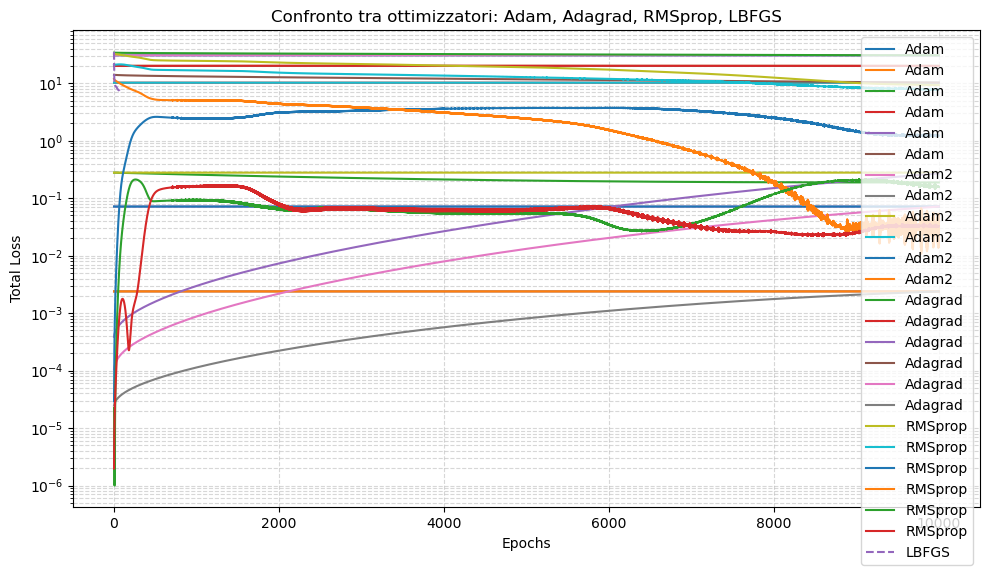

In [13]:

# Converti in array (nel caso siano liste)
loss_adam = np.array(loss_history_adam)
loss_adam2 = np.array(loss_history_adam2)
loss_adagrad = np.array(loss_history_adagrad)
loss_rmsprop = np.array(loss_history_rmsprop)
loss_lbfgs = np.array(loss_history_lbfgs)

# Epochs corrispondenti
epochs_adam = np.arange(1, len(loss_adam) + 1)
epochs_adam2 = np.arange(1, len(loss_adam2) + 1)
epochs_adagrad = np.arange(1, len(loss_adagrad) + 1)
epochs_rmsprop = np.arange(1, len(loss_rmsprop) + 1)
epochs_lbfgs = np.arange(1, len(loss_lbfgs) + 1)

# Plot
plt.figure(figsize=(10, 6))

plt.plot(epochs_adam, loss_adam, label='Adam', linewidth=1.5)
plt.plot(epochs_adam2, loss_adam2, label='Adam2', linewidth=1.5)
plt.plot(epochs_adagrad, loss_adagrad, label='Adagrad', linewidth=1.5)
plt.plot(epochs_rmsprop, loss_rmsprop, label='RMSprop', linewidth=1.5)
plt.plot(epochs_lbfgs, loss_lbfgs, label='LBFGS', linewidth=1.5, linestyle='--')

plt.yscale('log')  # scala log per vedere meglio la convergenza
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Confronto tra ottimizzatori: Adam, Adagrad, RMSprop, LBFGS")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


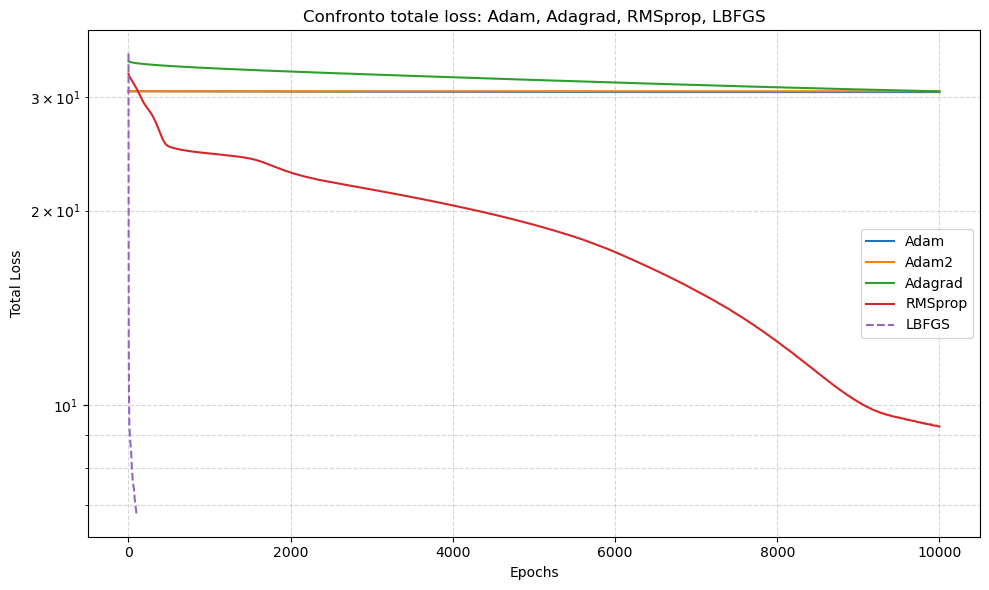

In [14]:

# Estrai la total loss (primo elemento) da ogni history
loss_adam_vals = [x[0] for x in loss_history_adam]
loss_adam2_vals = [x[0] for x in loss_history_adam2]
loss_adagrad_vals = [x[0] for x in loss_history_adagrad]
loss_rmsprop_vals = [x[0] for x in loss_history_rmsprop]
loss_lbfgs_vals = loss_history_lbfgs  # LBFGS è già lista di float (loss totale)

# Crea array di epoche per ogni ottimizzatore
epochs_adam = range(1, len(loss_adam_vals) + 1)
epochs_adam2 = range(1, len(loss_adam2_vals) + 1)
epochs_adagrad = range(1, len(loss_adagrad_vals) + 1)
epochs_rmsprop = range(1, len(loss_rmsprop_vals) + 1)
epochs_lbfgs = range(1, len(loss_lbfgs_vals) + 1)

# Plot
plt.figure(figsize=(10, 6))

plt.plot(epochs_adam, loss_adam_vals, label='Adam', linewidth=1.5)
plt.plot(epochs_adam2, loss_adam2_vals, label='Adam2', linewidth=1.5)
plt.plot(epochs_adagrad, loss_adagrad_vals, label='Adagrad', linewidth=1.5)
plt.plot(epochs_rmsprop, loss_rmsprop_vals, label='RMSprop', linewidth=1.5)
plt.plot(epochs_lbfgs, loss_lbfgs_vals, label='LBFGS', linewidth=1.5, linestyle='--')

plt.yscale('log')  # scala log per vedere meglio la convergenza
plt.xlabel("Epochs")
plt.ylabel("Total Loss")
plt.title("Confronto totale loss: Adam, Adagrad, RMSprop, LBFGS")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
